### Content:
- Use SpaCy NLP to find companys
- Match companys in news with stock companies (using regex)
- Exclude matches in headers afterwards (using regex)
- Apply NLP on one Reuters and one Bloomberg article as show cases
- Fix matchings for 3M Company
- Generate cooccurrences (value represents number of articles in which two companies occur together)

#### TODO:
- Read through some articles to find a show case how it relates to stock prices

In [225]:
import itertools
import os
import re
import glob
from datetime import datetime
import sys
from matplotlib.font_manager import FontProperties
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

import pandas as pd
import numpy as np
import tqdm
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

import src.nlp_utils as nlp_utils
import src.text_classification_utils as tc_utils

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'tagger'])

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 1.34 s


In [226]:
HOME = ".."
DATA_DIR = "data"
REUTERS = os.path.join(HOME, DATA_DIR, "preprocessed", "news_reuters.csv")
BLOOMBERG = os.path.join(HOME, DATA_DIR, "preprocessed", "news_bloomberg.csv")
ENTITIES_v1 = os.path.join("..", "data", "preprocessed", "entities.csv")
ENTITIES_v2 = os.path.join("..", "data", "preprocessed", "entities-v2.csv")
ENTITIES = ENTITIES_v2
OCCS = os.path.join(HOME, DATA_DIR, "preprocessed", "occurrences", "occurrences.csv")
# Numerical IDs (equals df index)
NEWS_v2 = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v2.csv")
# Sorted by date
NEWS_v3 = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v3.csv")
# Without all entities
NEWS_v4 = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v4.csv")
NEWS = NEWS_v3
# Columns: 'date', 'filename', 'content'

time: 266 ms


## Article Id Mapping

In [ ]:
news = pd.read_csv(NEWS, index_col=0)

# 8650 duplicated filenames, 786 duplicated contents
# d = news.filename.duplicated()
# print(news.loc[1716].iloc[1].content) # 1201 letters
# print(news.loc[1641].iloc[1].content) # 541 letters

In [ ]:
def get_old_idx(article):
    if article.reuters:
        return f'r{article.name}'
    return f'b{article.name}'

# [get_old_idx(idx, article) for idx, article in news.iterrows()];
news['old_idx'] = news.apply(get_old_idx, axis=1)

In [ ]:
news.reset_index(drop=True, inplace=True)
news = news[['old_idx', 'date', 'filename', 'content']]

new_to_old_idx = news.old_idx.to_dict()
old_to_new_idx = {v: k for k, v in new_to_old_idx.items()}

In [ ]:
news.to_csv('news-v2.csv')

## Sanity Check for Occurrences

In [ ]:
news = pd.read_csv(NEWS_v2, index_col=0)

In [ ]:
new_to_old_idx = news.old_idx.to_dict()
old_to_new_idx = {v: k for k, v in new_to_old_idx.items()}

In [ ]:
bb = pd.read_csv('../data/preprocessed/occurrences/occurrences-bloomberg-v2.csv', index_col=0)
re = pd.read_csv('../data/preprocessed/occurrences/occurrences-reuters-v2.csv', index_col=0)

In [ ]:
n_tests = 100000
# for idx in tqdm(np.random.choice(len(re), n_tests, replace=False)):
#     occurrence = re.iloc[idx]
for idx in tqdm(np.random.choice(len(bb), n_tests, replace=False)):
    occurrence = bb.iloc[idx]
    str_in_article = news.loc[old_to_new_idx[occurrence.article_id]].content[occurrence.start_idx:occurrence.end_idx]
    assert str_in_article == occurrence.match_text, f"Didn't match for occurrence {idx}"

In [ ]:
re.article_id = re.article_id.apply(old_to_new_idx.get)
bb.article_id = bb.article_id.apply(old_to_new_idx.get)
occurrences = pd.concat([re, bb])

n_tests = 100000
for idx in tqdm(np.random.choice(len(occurrences), n_tests, replace=False)):
    occurrence = occurrences.iloc[idx]
    str_in_article = news.loc[occurrence.article_id].content[occurrence.start_idx:occurrence.end_idx]
    assert str_in_article == occurrence.match_text, f"Didn't match for occurrence {idx}"

## Sanity Check for Entities

In [ ]:
entities = pd.read_csv(ENTITIES, index_col=0, nrows=10000)
news = pd.read_csv(NEWS, index_col=0, nrows=10000)

In [ ]:
nan_txt_entities = entities[entities.match_text.isna()]
txts = []
for _, row in nan_txt_entities.iterrows():
    txts.append(news.loc[row.article_id].content[row.start_idx:row.end_idx])
txts = np.array(txts)
print(np.unique(txts))  # -> N/A or NA with das transformed in real nan values
# In entities.csv the files is empty -> e.g. line 2335779: "2291077,39064,,1172,1174,ORG"

In [ ]:
n_tests = 10000
for idx in tqdm(np.random.choice(len(entities), n_tests, replace=False)):
    entity = entities.iloc[idx]
    str_in_article = news3.loc[entity.article_id].content[entity.start_idx:entity.end_idx]
    assert (isinstance(entity.match_text, float) and np.isnan(entity.match_text)) or str_in_article == entity.match_text, f"Didn't match entity at {idx}"

## News-v3
Reuters and Bloomberg are now mixed because they are sorted by date. This does not change the indexes.

In [ ]:
news = pd.read_csv(NEWS_v2, index_col=0)
news.date = pd.to_datetime(news.date)
news = news.sort_values(by=['date'])

In [ ]:
with open(NEWS_v3, mode='w', newline='\n', encoding='utf-8') as f:
    news.to_csv(f, line_terminator='\n', encoding='utf-8')

### Testing HDF5
Performance roughly as good as csv. --> http://matthewrocklin.com/blog/work/2015/03/16/Fast-Serialization

In [ ]:
news.to_hdf(NEWS_v3[:-3]+'h5', 'df')

In [ ]:
news = pd.read_hdf(NEWS_v3[:-3]+'h5')

Note: v3 contained \r\r for each \r because of Windows line formatting rules

## Replace entities

#### Merge Entities and Occs

In [ ]:
news = pd.read_csv(NEWS_v3, index_col=0)

In [3]:
entities = pd.read_csv(ENTITIES_v1, index_col=0)
occs = pd.read_csv(OCCS, index_col=0)

c:\users\thomas\hpi\ma\venv\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 53.6 s


In [4]:
entities = nlp_utils.merge_entities_and_occs(entities, occs, quiet=False)

Frames are merged
time: 1min 22s


In [5]:
entities.sort_values(by=['article_id', 'start_idx'], ascending=[True, False], inplace=True)

time: 53.4 s


In [6]:
with open(ENTITIES_v2, mode='w', newline='\n', encoding='utf-8') as f:
    entities.to_csv(f, line_terminator='\n', encoding='utf-8')

time: 4min 19s


### Notes
- 2.3 mio ORG entities start with an empty space. This might led to not matching stock symbols. (Example " Exxon Mobile")
- Entity Labels: ['ORG', 'GPE', 'MONEY', 'DATE', 'QUANTITY', 'CARDINAL', 'NORP', 'PERSON', 'PRODUCT', 'LAW', 'PERCENT']
- Company Occurrences are marked with < SYM >

In [7]:
entities = pd.read_csv(ENTITIES_v2, index_col=0)

c:\users\thomas\hpi\ma\venv\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 1min


In [ ]:
grouped = entities.groupby('article_id', sort=False)

In [ ]:
def remove_substr(s, to_idx, from_idx):
    return s[:to_idx]+s[from_idx:]

In [ ]:
for article_id, group in tqdm(grouped, total=len(grouped.groups)):
    # group.sort_values(by='start_idx', inplace=True, ascending=False)
    s = news.loc[article_id].content
    for i, row in group.iterrows():
        # print(news.loc[0].content[row.start_idx-2:row.end_idx+2])
        # Plus 1 for end_idx so the next sign (probably a space) will also be removed
        s = remove_substr(s, row.start_idx, row.end_idx+1)
        # print(s[row.start_idx-2:row.end_idx+2])
    news.loc[article_id].content = s
    # print(s)
    # assert False

In [ ]:
NEWS_v4 = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v4.csv")
with open(NEWS_v4, mode='w', newline='\n', encoding='utf-8') as f:
    news.to_csv(f, line_terminator='\n', encoding='utf-8')

# Collect & Plot for paper

In [336]:
news = pd.read_csv(NEWS_v4)
news['is_reuter']= news.old_idx.str.slice(0, 1) == 'r'
news = news[['date', 'is_reuter', 'content', 'filename']]
news.set_index(pd.DatetimeIndex(news.date.rename('index')), inplace=True)
news.date = pd.to_datetime(news.date)

time: 27.1 s


### Inspect & Remove Duplicates

In [616]:
element_group_sizes = news.filename.groupby(news.filename).transform('size')  # Much more efficient than filter()
only_duplicated_articles = news[element_group_sizes > 1]

time: 2.02 s


In [658]:
# Inspect properties of duplicates
def timedelta(x):
    return x.max() - x.min()

def mean_changes(x):
    return abs(x[:-1].str.len() - x.shift(-1)[:-1].str.len()).mean()

def min_len(x):
    return min(x.str.len())

def max_len(x):
    return max(x.str.len())

group_props = only_duplicated_articles.groupby('filename').agg({ 'date': [min, max, len, timedelta], 'content': [mean_changes, min_len, max_len] })
group_props.head()

date                 \
                                                          min        max len   
filename                                                                       
-a-dodgers-owner-frank-mccourt-says-divorce-set... 2010-11-30 2010-12-01   2   
-dark-knight-weekend-sales-below-estimates-anal... 2012-07-22 2012-07-23   2   
-despicable-me-2-tops-depp-s-lone-ranger-for-ho... 2013-07-07 2013-07-08   2   
-evangile-2010-falls-to-lowest-level-since-rele... 2013-08-05 2013-10-23   2   
-hobbit-repeats-as-top-movie-with-37-million-in... 2012-12-23 2012-12-24   2   

                                                                  content  \
                                                   timedelta mean_changes   
filename                                                                    
-a-dodgers-owner-frank-mccourt-says-divorce-set...    1 days       1431.0   
-dark-knight-weekend-sales-below-estimates-anal...    1 days          5.0   
-despicable-me-2-tops-depp-s-lone-ranger-for-ho...    1 days       2080.0   
-evangile-2010-falls-to-lowest-level-since-rele...   79 days         92.0   
-hobbit-repeats-as-top-movie-with-37-million-in...    1 days         19.0   

                                                                    
                                                   min_len max_len  
filename                                                            
-a-dodgers-owner-frank-mccourt-says-divorce-set...     470    1901  
-dark-knight-weekend-sales-below-estimates-anal...    3763    3768  
-despicable-me-2-tops-depp-s-lone-ranger-for-ho...    2370    4450  
-evangile-2010-falls-to-lowest-level-since-rele...    1677    1769  
-hobbit-repeats-as-top-movie-with-37-million-in...    3741    3760

time: 6.02 s


In [452]:
# 'certificate-of-deposits-reported-india-money-markets' occurs 568 times, "Following is a table showing certificate of deposits"
# 'commercial-papers-reported-india-money-markets' occurs 378 times, "Following is a table showing commercial papers"
# 'india-s-bse-and-nse-equity-derivative-market-activity' occurs 332 times, "Following are the highlights for the \nequity derivative market activity"
# 'fed-funds-open-at-0-16-within-target-range-according-to-icap' occurs 17 times, 
# 3685 filenames are occurring multiple times, covering 12028 entries
duplicated_title = 'fed-funds-open-at-0-16-within-target-range-according-to-icap'

time: 228 ms


### Filtering

Starting with: 106.519 Reuters, 448.395 Bloomberg, 554.914 articles in total

1. Content empty: 25 Reuters, 628 Bloomberg
2. Less than 300 chars: 1253 Reuters, 2148 Bloomberg
3. Drop duplicates keeping the last occurrence: 8343 removed for 3685 articles (e.g. 'certificate-of-deposits-reported-india-money-markets' occurs 568 times)

-> Results in 105.241 Reuters and 445.619 Bloomberg, 542.517 articles in total

In [686]:
news = news[news.content.notna()]
news = news[news.content.str.len() >= 300]
news.drop_duplicates('filename', keep='last', inplace=True)

time: 1.1 s


### Plot Distribution of Left Articles

In [688]:
reuters_daily_counts = news[['is_reuter', 'date']].groupby('date').sum().astype(int)
reuters_daily_counts.set_index(pd.DatetimeIndex(reuters_daily_counts.index), inplace=True)
reuters_quarterly_counts = reuters_daily_counts.resample('Q', convention='end').agg('sum')

time: 273 ms


In [689]:
bloomberg_daily_counts = news[['is_reuter', 'date']].groupby('date').count() - reuters_daily_counts
bloomberg_daily_counts.set_index(pd.DatetimeIndex(bloomberg_daily_counts.index), inplace=True)
bloomberg_quarterly_counts = bloomberg_daily_counts.resample('Q', convention='end').agg('sum')

time: 248 ms


In [690]:
quarterly_counts = pd.concat([reuters_quarterly_counts, bloomberg_quarterly_counts], axis=1)
quarterly_counts.columns = ['Reuters', 'Bloomberg']

time: 197 ms


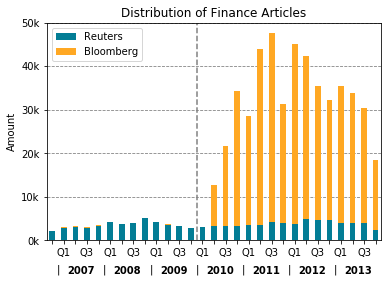

time: 793 ms


In [691]:
labels = ['Q4'] + [f'{q}' for y, q in itertools.product(range(2007, 2014), ['Q1', 'Q2', 'Q3', 'Q4'])]
labels = [x if x in ['Q1', 'Q3'] else '' for x in labels]
ax = quarterly_counts.plot.bar(legend=True, stacked=True, color=['#037d95', '#ffa823'])
ax.set_xlabel('')
ax.set_ylabel('Amount')
ax.set_title('Distribution of Finance Articles')


ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation='horizontal')

y_axis_title_pos = 1
ax.text(0.7, -6700, '|', ha='right', va='center')
for idx, year in enumerate(range(2007, 2014)):
    title_pos = y_axis_title_pos + 1.5
    ax.text(title_pos, -7000, year, ha='center', va='center', rotation=0,
            fontproperties=FontProperties(weight='bold'))
    if year < 2013:
        sep_pos = y_axis_title_pos + 3.7
        ax.text(sep_pos, -6700, '|', ha='right', va='center')
    y_axis_title_pos += 4

ax.set_yticklabels([f'{abs(x / 1000):n}k' for x in ax.get_yticks()])

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.axvline(12.5, linestyle='dashed', color='gray')
plt.gcf().savefig('articles-distribution.pdf')